In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from model_generation import generate_model

model = generate_model()

C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model3 = generate_model(noise=True)
model4 = generate_model(nums=[0,1],name="keras_mnist_model_zero_onev1.h5")

In [4]:
model5 = generate_model(nums=[0,1,2], name="keras_mnist_model_zero_to_twov1.h5")

In [5]:
model6 = generate_model(nums=[0,1,2,3], name="keras_mnist_model_zero_to_threev1.h5")

In [6]:
model7 = generate_model(nums=[1,7], name="keras_mnist_model_one_sevenv1.h5")

In [172]:
model8 = generate_model(nums=[0,1,7], name="keras_mnist_model_zero_one_sevenv1.h5")

In [5]:
X_train_noise, X_test_noise, Y_train, Y_test = generate_data(noise=True)
score = model.evaluate(X_test_noise, Y_test, verbose=0)
print(score)
score = model3.evaluate(X_test_noise, Y_test, verbose=0)
print(score)

[0.7950517480492592, 0.8241]
[0.7950517480492592, 0.8241]


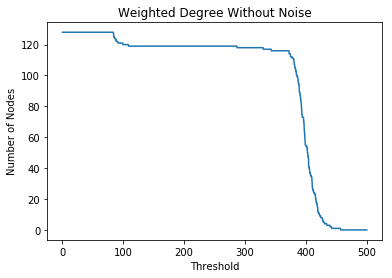

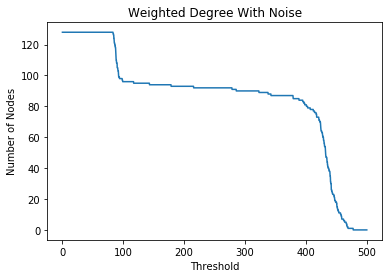

In [4]:
# function counting the number of nodes above a threshold
def thresh_count(arr, thresh):
    return(np.sum(arr > thresh))


def plot_l1_norm(model, title=""):
    # get the dense layer
    dense_layer= model.layers[-3]

    # pull out the weights
    dense_weights = np.array(dense_layer.get_weights())

    # compute the L1 norm for the dense weights
    dense_L1 = np.sum(np.abs(dense_weights[0]), axis = 0)

    # list of thresholds
    thresh_list = np.linspace(0,500, 2000)

    # count the number of nodes for all thresholds
    dense_count = np.array([thresh_count(dense_L1, thresh) for thresh in thresh_list])

    # plot count vs. thresh
    plt.plot(thresh_list, dense_count)
    plt.xlabel("Threshold")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    plt.show()
    
plot_l1_norm(model, title="Weighted Degree Without Noise")
plot_l1_norm(model3, title="Weighted Degree With Noise")

In [10]:
weights = np.abs(np.array(model.layers[-1].get_weights()[0]))
print(weights.shape)
weight_adj_matrix = np.zeros([sum(weights.shape),sum(weights.shape)])
weight_adj_matrix[weights.shape[0]:,:weights.shape[0]] = np.transpose(weights)
print(weight_adj_matrix)

(128, 10)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.17235444 0.05914584 0.00919179 ... 0.         0.         0.        ]
 [0.39859247 0.14722274 0.36580205 ... 0.         0.         0.        ]
 [0.18943426 0.11194394 0.09362796 ... 0.         0.         0.        ]]


In [9]:
import bct
# bct.betweenness_wei(weight_adj_matrix)

In [56]:
def weighted_clustering_coeff(G):
    """ Calculates clustering coefficient for a weighted network represented by an adjacency matrix """
    # https://www.researchgate.net/publication/49721057_Competition_for_Popularity_in_Bipartite_Networks
    k = G.shape[0] # assume fully connected
    coeffs = np.zeros((k,))
    for i in range(k):
        for j in range(k):
            for h in range(k):
                coeffs[i] += (G[i,j]*G[i,h]*G[h,j])**(1.0/3.0)
        Gv = np.max(G[i,:])
        coeffs[i] *= 2.0/(k*(k-1)*Gv)
    return coeffs

def calc_clustering_coeff_square(weights):
    """ Calculates clustering coefficients for a bipartite weighted network represented by a weight matrix """
    # Compute the unipartite networks correspondign to the bipartite network
    adj1 = np.matmul(weights, np.transpose(weights))
    adj2 = np.matmul(np.transpose(weights), weights)
    return weighted_clustering_coeff(adj1), weighted_clustering_coeff(adj2)

In [57]:
coeffs1, coeffs2 = calc_clustering_coeff_square(weights)

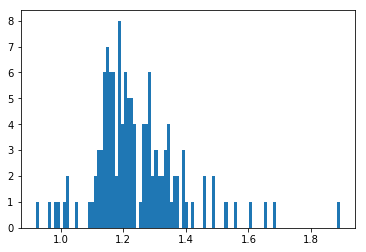

1.2418992631635395


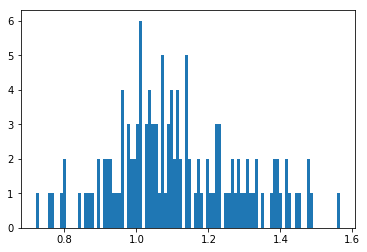

1.1156579708177847


In [59]:
# plt.hist(coeffs1, bins=100, cumulative=True)
plt.hist(coeffs1, bins=100)
plt.show()
print(np.average(coeffs1))

weights_noise = np.abs(np.array(model3.layers[-1].get_weights()[0]))
coeffs1_noise, coeffs2_noise = calc_clustering_coeff_square(weights_noise)
# plt.hist(coeffs1_noise, bins=100, cumulative=True)
plt.hist(coeffs1_noise, bins=100)
plt.show()
print(np.average(coeffs1_noise))

In [185]:
from keras import backend as K

m = model
nums = None
# n = len(nums)

weights = np.array(m.layers[-3].get_weights()[0]).transpose()
# Compute the adjacency matrix of the layer
# layer_adj_matrix = np.matmul(weights, np.transpose(weights))

# Permute the weights randomly to prevent indexing bias
perm = np.random.permutation(weights.shape[0])
weights = weights[perm]

weights_norm = np.linalg.norm(weights[:,:], axis=1)
# print(weights_norm)
print(np.diag(np.reciprocal(weights_norm)).shape)
# Normalize weights
weights_normed = np.matmul(np.diag(np.reciprocal(weights_norm)), weights)
layer_adj_matrix = np.matmul(weights_normed[:,:], np.transpose(weights_normed[:,:]))

# # Compute a layer adjacency matrix composed of 2 nodes repeated 64 times
# print(weights.shape)
# weights_fake = np.concatenate([weights_normed[:16,:]]*8)
# print(weights_fake.shape)
# layer_adj_matrix = np.matmul(weights_fake, np.transpose(weights_fake))

(128, 128)


In [186]:
# Find the highest activation image for each node in the first dense layer
from model_generation import generate_data
X_train, X_test, Y_train, Y_test = generate_data(nums=nums)

inp = m.input                                           # input placeholder
outputs = [m.layers[-3].output, m.layers[-1].output]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
test = X_test[:5000]
# test = X_test_zero_one[:]
layer_outs = functor([test, 1.])
layer_outs_2 = functor([X_test[5000:10000], 1.])
layer_outs = [np.append(layer_outs[0], layer_outs_2[0], axis=0)]
print(layer_outs[0].shape)

(10000, 128)


In [187]:
# Determine index of maximum activation image
max_vals = np.max(layer_outs[0],axis=0)[perm]
# print(max_vals)
repr_indices = np.argmax(np.abs(layer_outs[0]), axis=0)[perm]
# print(np.argmax(layer_outs[0],axis=1))
print(layer_adj_matrix[max_vals!=0][:,max_vals!=0].shape)

(120, 120)


In [188]:
# Create label with mode of top 9 activations
from scipy import stats
top9 = np.argsort(np.abs(layer_outs[0]), axis=0)[-9:,:]
labels = np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]]
labels_top9 = stats.mode(np.argmax(Y_test,axis=1)[top9])[0][0][perm]
labels_orig = np.argmax(Y_test,axis=1)[repr_indices]
# If the mode count is too low, favor the original labels
low_mode = stats.mode(np.argmax(Y_test,axis=1)[top9])[1][0][perm]<5
labels_top9[low_mode] = labels_orig[low_mode]
labels_top9 = labels_top9[max_vals!=0]

In [189]:
# print(layer_outs[1].shape)
print(np.min(weights))
print(np.min(layer_outs[0]))
print(np.sum(weights[:,:2], axis=0))
best_partners = np.argmax(layer_adj_matrix-np.eye(layer_adj_matrix.shape[0]),axis=0)
labels = np.argmax(Y_test,axis=1)[repr_indices]
# print(labels)
# print(best_partners)
# for i in range(len(best_partners)):
#     print(labels[i]-labels[best_partners[i]])

-0.6088943
0.0
[0.85106385 1.7453756 ]


In [190]:
layer_adj_matrix = layer_adj_matrix[max_vals!=0][:,max_vals!=0]
print(np.max(layer_adj_matrix - layer_adj_matrix.transpose()))

0.0


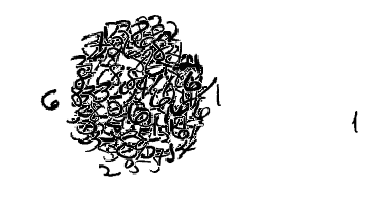

In [191]:
import networkx as nx
from networkx.drawing import spring_layout, spectral_layout, kamada_kawai_layout

# thresh = np.percentile(np.abs(layer_adj_matrix), 10)
# layer_adj_matrix[np.abs(layer_adj_matrix)<thresh] = 0.0

inv_adj_matrix = np.reciprocal(layer_adj_matrix)
# Truncate high values
thresh = np.percentile(inv_adj_matrix, 90)
inv_adj_matrix[inv_adj_matrix>thresh] = 0.0
inv_adj_matrix[inv_adj_matrix<0] = 0.0


# G = nx.Graph(layer_adj_matrix)
# G = nx.Graph(inv_adj_matrix, width=inv_adj_matrix)

# Remove disconnected nodes
# max_vals2 = np.max(inv_adj_matrix, axis=0)
# inv_adj_matrix = inv_adj_matrix[max_vals2!=0][:,max_vals2!=0]


G = nx.Graph(inv_adj_matrix)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40, weight='weight')
layout = kamada_kawai_layout(G, weight='weight')

fig = plt.Figure()
# Generate the image
n = len(layout)
# for i in range(n):
#     for j in range(n):
#         if inv_adj_matrix[i,j]<0.6:
#             pos1 = layout[i]*200
#             pos2 = layout[j]*200
#             plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], alpha=0.05, color="black")
        
for i in range(n):
    pos = layout[i]*200
    extent = [pos[0]-14, pos[0]+14, pos[1]-14, pos[1]+14]
#     img = X_test[repr_indices[i]][0].copy()
    img = X_test[repr_indices[max_vals!=0][i]][0].copy()
#     img = X_test_zero_one[repr_indices[max_vals!=0][i]][0].copy()
#     # add a black border
#     for i in range(len(img)):
#         img[i][0] = 1
#         img[i][-1] = 1
#         for j in range(len(img[0])):
#             img[0][j] = 1
#             img[-1][j] = 1
    img = np.ma.masked_where(img == 0, img)
    plt.imshow(img, interpolation="nearest", extent=extent, cmap="binary")
plt.autoscale()
plt.axis("off")
plt.show()

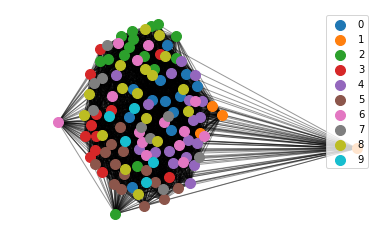

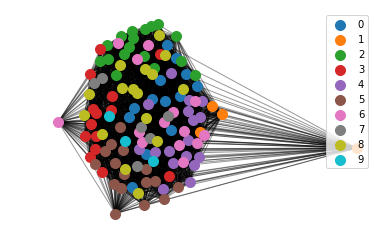

In [192]:
import networkx as nx
from networkx.drawing import spring_layout, spectral_layout, kamada_kawai_layout
from functools import reduce

# thresh = np.percentile(np.abs(layer_adj_matrix), 10)
# layer_adj_matrix[np.abs(layer_adj_matrix)<thresh] = 0.0

inv_adj_matrix = np.reciprocal(layer_adj_matrix)
# Truncate high values
thresh = np.percentile(inv_adj_matrix, 100)
inv_adj_matrix[inv_adj_matrix>thresh] = 0.0
inv_adj_matrix[inv_adj_matrix<0] = 0.0

# layer_adj_matrix2 = layer_adj_matrix.copy()
# layer_adj_matrix2[layer_adj_matrix2<0] = 0.0
# thresh = np.percentile(layer_adj_matrix2, 50)
# layer_adj_matrix2[layer_adj_matrix2>thresh] = 0.0

G = nx.Graph(inv_adj_matrix)
# G = nx.Graph(layer_adj_matrix2)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40, weight='weight')
layout = kamada_kawai_layout(G, weight='weight')

plt.figure()
# Plot each digit as a different color
labels = np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]]
for i in range(max(nums if nums else [9])+1):
    digit_set = [x[0] for x in np.argwhere(labels==i)]
    # nodes
    nx.draw_networkx_nodes(G,layout,
                           nodelist=digit_set,
                           node_color='C{}'.format(i),
                           node_size=100)

# edges
nx.draw_networkx_edges(G,layout,width=1.0,alpha=0.4)
plt.legend(list(map(str,nums if nums else range(10))))
plt.axis('off')
plt.show()
plt.figure()
# Plot each digit as a different color
labels = np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]]
for i in range(max(nums if nums else [9])+1):
    digit_set = [x[0] for x in np.argwhere(labels_top9==i)]
    # nodes
    nx.draw_networkx_nodes(G,layout,
                           nodelist=digit_set,
                           node_color='C{}'.format(i),
                           node_size=100)

# edges
nx.draw_networkx_edges(G,layout,width=1.0,alpha=0.4)
plt.legend(list(map(str,nums if nums else range(10))))
plt.axis('off')
plt.show()

In [170]:
from networkx.algorithms.community import girvan_newman
from networkx import edge_betweenness_centrality
def weighted_centrality(G):
    return max(edge_betweenness_centrality(G, weight='weight').items(), key=lambda x:x[1])[0]
communities = girvan_newman(G, weighted_centrality)

In [90]:
communities = girvan_newman(G)

In [169]:
from networkx.algorithms.community import asyn_lpa_communities
communities = asyn_lpa_communities(G, weight='weight')
# for x in communities:
# #     print(x)
#     print([labels_top9[i] for i in x])

In [81]:
ebc = edge_betweenness_centrality(G, weight='weight')
# print(ebc)
print(max(ebc.items(), key=lambda x:x[1]))

((10, 62), 0.17817974647486112)


In [171]:
for x in communities:
    print(x)
    for community in x:
        print([labels[i] for i in community])
#     print([labels[i] for i in x])

({0, 1, 2, 4, 5, 6, 9, 11, 13, 15, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 32, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 57, 58, 59, 60, 61, 62, 63, 66, 67, 68, 70, 72, 73, 75, 77, 78, 79, 80, 81, 82, 84, 85, 87, 88, 90, 93, 95, 96, 97, 99, 103, 104, 105, 109, 110, 112, 113, 114, 118}, {3, 7, 8, 10, 12, 14, 16, 17, 18, 26, 28, 33, 37, 38, 51, 53, 55, 56, 64, 65, 69, 71, 74, 76, 83, 86, 89, 91, 92, 94, 98, 100, 101, 102, 106, 107, 108, 111, 115, 116, 117})
[2, 6, 2, 8, 4, 2, 3, 8, 7, 8, 8, 8, 2, 2, 8, 5, 2, 6, 6, 7, 4, 0, 0, 8, 0, 4, 4, 0, 0, 8, 0, 4, 4, 7, 6, 4, 0, 4, 4, 0, 8, 2, 7, 2, 6, 3, 0, 0, 2, 2, 2, 7, 8, 4, 4, 0, 4, 7, 6, 8, 6, 8, 2, 6, 8, 2, 4, 3, 1, 6, 8, 2, 4, 4, 1, 1, 4, 3]
[4, 3, 5, 0, 8, 5, 8, 5, 2, 3, 5, 6, 3, 3, 9, 3, 5, 5, 5, 8, 6, 6, 4, 8, 9, 5, 9, 0, 7, 4, 8, 5, 0, 9, 5, 3, 5, 3, 3, 3, 5]
({0, 1, 2, 4, 5, 6, 9, 11, 13, 15, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 32, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 

({0, 2, 5, 6, 9, 11, 15, 19, 20, 21, 22, 23, 25, 27, 32, 34, 41, 43, 48, 50, 59, 60, 61, 62, 67, 68, 70, 72, 73, 75, 85, 87, 88, 95, 97, 105, 110, 118}, {1}, {3, 7, 8, 10, 12, 14, 16, 17, 18, 26, 28, 33, 37, 38, 53, 55, 56, 64, 65, 69, 71, 74, 76, 83, 86, 89, 91, 94, 98, 100, 101, 102, 106, 108, 111, 115, 116, 117}, {4, 13, 24, 29, 30, 31, 35, 39, 40, 42, 44, 45, 46, 47, 49, 52, 57, 58, 77, 79, 81, 82, 84, 90, 93, 96, 99, 103, 112, 113, 114}, {54, 36, 78, 63}, {51}, {66}, {80}, {92}, {104}, {107}, {109})
[2, 2, 4, 2, 3, 8, 8, 8, 8, 2, 2, 8, 2, 6, 0, 0, 0, 8, 6, 0, 2, 7, 2, 6, 0, 2, 2, 2, 7, 8, 6, 8, 2, 2, 3, 2, 4, 3]
[6]
[4, 3, 5, 0, 8, 5, 8, 5, 2, 3, 5, 6, 3, 3, 3, 5, 5, 5, 8, 6, 6, 4, 8, 9, 5, 9, 0, 4, 8, 5, 0, 9, 5, 5, 3, 3, 3, 5]
[8, 7, 5, 6, 7, 4, 8, 4, 4, 0, 0, 4, 4, 7, 4, 4, 0, 8, 4, 0, 7, 6, 8, 6, 8, 4, 1, 6, 1, 1, 4]
[4, 0, 4, 3]
[9]
[0]
[4]
[7]
[8]
[3]
[4]
({0, 2, 5, 6, 9, 11, 15, 19, 20, 21, 22, 23, 25, 27, 32, 34, 41, 43, 48, 50, 59, 60, 61, 62, 67, 68, 70, 72, 73, 75, 85, 

({0, 2, 5, 6, 15, 19, 20, 21, 22, 23, 25, 27, 32, 34, 41, 43, 48, 50, 59, 60, 61, 62, 67, 70, 72, 73, 75, 85, 87, 88, 95, 105, 110, 118}, {1}, {3, 8, 10, 12, 14, 17, 26, 28, 33, 37, 38, 53, 55, 56, 64, 65, 69, 71, 74, 76, 83, 86, 89, 91, 94, 98, 100, 101, 102, 106, 108, 111, 116, 117}, {4, 13, 24, 29, 30, 31, 35, 39, 40, 45, 46, 47, 49, 57, 58, 77, 79, 81, 82, 84, 90, 93, 96, 99, 103, 112, 113, 114}, {7}, {9}, {11}, {16}, {18}, {54, 36, 78, 63}, {42, 52}, {44}, {51}, {66}, {68}, {80}, {92}, {97}, {104}, {107}, {109}, {115})
[2, 2, 4, 2, 8, 8, 8, 2, 2, 8, 2, 6, 0, 0, 0, 8, 6, 0, 2, 7, 2, 6, 0, 2, 2, 7, 8, 6, 8, 2, 2, 2, 4, 3]
[6]
[4, 5, 0, 8, 5, 5, 3, 5, 6, 3, 3, 3, 5, 5, 5, 8, 6, 6, 4, 8, 9, 5, 9, 0, 4, 8, 5, 0, 9, 5, 5, 3, 3, 5]
[8, 7, 5, 6, 7, 4, 8, 4, 4, 4, 4, 7, 4, 0, 8, 4, 0, 7, 6, 8, 6, 8, 4, 1, 6, 1, 1, 4]
[3]
[3]
[8]
[8]
[2]
[4, 0, 4, 3]
[0, 4]
[0]
[9]
[0]
[2]
[4]
[7]
[3]
[8]
[3]
[4]
[3]
({0, 2, 5, 6, 15, 19, 20, 21, 22, 23, 25, 27, 32, 34, 41, 43, 48, 50, 59, 60, 61, 62, 67, 7

({0, 2, 5, 6, 15, 19, 20, 22, 23, 25, 27, 32, 34, 41, 43, 48, 50, 59, 60, 61, 62, 67, 70, 72, 73, 75, 85, 87, 88, 95, 105}, {1}, {3, 8, 10, 12, 14, 17, 26, 28, 33, 37, 38, 53, 55, 56, 64, 65, 69, 71, 76, 83, 86, 89, 94, 100, 101, 102, 106, 108, 111, 116, 117}, {4, 24, 29, 30, 31, 35, 39, 40, 45, 46, 49, 57, 77, 79, 81, 82, 90, 93, 96, 99, 103, 112, 113, 114}, {7}, {9}, {11}, {84, 13}, {16}, {18}, {21}, {54, 36, 78, 63}, {42, 52}, {44}, {47}, {51}, {58}, {66}, {68}, {74}, {80}, {91}, {92}, {97}, {98}, {104}, {107}, {109}, {110}, {115}, {118})
[2, 2, 4, 2, 8, 8, 8, 2, 8, 2, 6, 0, 0, 0, 8, 6, 0, 2, 7, 2, 6, 0, 2, 2, 7, 8, 6, 8, 2, 2, 2]
[6]
[4, 5, 0, 8, 5, 5, 3, 5, 6, 3, 3, 3, 5, 5, 5, 8, 6, 6, 8, 9, 5, 9, 4, 5, 0, 9, 5, 5, 3, 3, 5]
[8, 5, 6, 7, 4, 8, 4, 4, 4, 4, 4, 0, 4, 0, 7, 6, 6, 8, 4, 1, 6, 1, 1, 4]
[3]
[3]
[8]
[8, 7]
[8]
[2]
[2]
[4, 0, 4, 3]
[0, 4]
[0]
[7]
[9]
[8]
[0]
[2]
[4]
[4]
[0]
[7]
[3]
[8]
[8]
[3]
[4]
[4]
[3]
[3]
({0, 5, 6, 15, 19, 20, 22, 23, 25, 27, 32, 34, 41, 43, 50, 59, 6

({0, 5, 6, 15, 19, 22, 23, 25, 27, 32, 34, 43, 50, 59, 60, 61, 62, 67, 70, 72, 75, 85, 87, 88, 95, 105}, {1}, {48, 2}, {3, 8, 12, 14, 17, 28, 33, 37, 38, 53, 55, 56, 65, 69, 71, 76, 86, 89, 100, 101, 102, 106, 108, 111, 116, 117}, {4, 24, 29, 30, 31, 35, 39, 40, 45, 46, 49, 57, 77, 79, 82, 90, 93, 96, 99, 103, 112, 113, 114}, {7}, {9}, {10}, {11}, {84, 13}, {16}, {18}, {20}, {21}, {26, 83}, {54, 36, 78, 63}, {41}, {42, 52}, {44}, {47}, {51}, {58}, {64}, {66}, {68}, {73}, {74}, {80}, {81}, {91}, {92}, {94}, {97}, {98}, {104}, {107}, {109}, {110}, {115}, {118})
[2, 4, 2, 8, 8, 2, 8, 2, 6, 0, 0, 8, 0, 2, 7, 2, 6, 0, 2, 2, 8, 6, 8, 2, 2, 2]
[6]
[6, 2]
[4, 5, 8, 5, 5, 5, 6, 3, 3, 3, 5, 5, 8, 6, 6, 8, 5, 9, 5, 0, 9, 5, 5, 3, 3, 5]
[8, 5, 6, 7, 4, 8, 4, 4, 4, 4, 4, 0, 4, 0, 6, 6, 8, 4, 1, 6, 1, 1, 4]
[3]
[3]
[0]
[8]
[8, 7]
[8]
[2]
[8]
[2]
[3, 9]
[4, 0, 4, 3]
[0]
[0, 4]
[0]
[7]
[9]
[8]
[5]
[0]
[2]
[7]
[4]
[4]
[7]
[0]
[7]
[4]
[3]
[8]
[8]
[3]
[4]
[4]
[3]
[3]
({0, 6, 15, 19, 22, 23, 25, 27, 32, 3

({0, 34, 6, 70, 72, 105, 75, 50, 87, 25, 27, 62}, {1}, {48, 2}, {3, 8, 12, 14, 17, 28, 33, 37, 38, 55, 56, 65, 69, 71, 76, 86, 100, 101, 102, 106, 108, 111, 116, 117}, {96, 4, 40, 46, 93, 24, 57, 29, 31}, {5}, {7}, {9}, {10}, {11}, {84, 13}, {88, 43, 67, 15}, {16}, {18}, {19, 60}, {20}, {21}, {22}, {23}, {26, 83}, {35, 99, 39, 103, 77, 45, 79, 112, 49, 82, 113, 114, 90, 30}, {32, 61, 59, 85, 95}, {54, 36, 78, 63}, {41}, {42, 52}, {44}, {47}, {51}, {53}, {58}, {64}, {66}, {68}, {73}, {74}, {80}, {81}, {89}, {91}, {92}, {94}, {97}, {98}, {104}, {107}, {109}, {110}, {115}, {118})
[2, 0, 2, 2, 2, 2, 8, 0, 8, 2, 6, 6]
[6]
[6, 2]
[4, 5, 8, 5, 5, 5, 6, 3, 3, 5, 5, 8, 6, 6, 8, 5, 5, 0, 9, 5, 5, 3, 3, 5]
[4, 8, 4, 4, 8, 5, 0, 6, 4]
[4]
[3]
[3]
[0]
[8]
[8, 7]
[2, 8, 0, 8]
[8]
[2]
[8, 7]
[8]
[2]
[2]
[8]
[3, 9]
[8, 1, 4, 6, 4, 4, 0, 1, 4, 6, 1, 4, 6, 7]
[0, 2, 2, 6, 2]
[4, 0, 4, 3]
[0]
[0, 4]
[0]
[7]
[9]
[3]
[8]
[5]
[0]
[2]
[7]
[4]
[4]
[7]
[9]
[0]
[7]
[4]
[3]
[8]
[8]
[3]
[4]
[4]
[3]
[3]
({0, 34, 6

({0, 34, 70, 72, 105, 75, 50, 87, 27}, {1}, {48, 2}, {65, 3, 37, 38, 101, 8, 106, 14, 111, 116, 117, 56}, {96, 4, 40, 46, 93, 24, 57, 29, 31}, {5}, {62, 25, 6}, {7}, {9}, {10}, {11}, {17, 12}, {84, 13}, {88, 43, 67, 15}, {16}, {18}, {19, 60}, {20}, {21}, {22}, {23}, {26, 83}, {28}, {99, 30, 79}, {32, 61, 59, 85, 95}, {33, 100, 76}, {35, 103, 39, 45, 77, 112, 113, 82, 49, 114, 90}, {54, 36, 78, 63}, {41}, {42, 52}, {44}, {47}, {51}, {53}, {69, 55}, {58}, {64}, {66}, {68}, {71}, {73}, {74}, {80}, {81}, {108, 86}, {89}, {91}, {92}, {94}, {97}, {98}, {102}, {104}, {107}, {109}, {110}, {115}, {118})
[2, 0, 2, 2, 2, 8, 0, 8, 6]
[6]
[6, 2]
[8, 4, 3, 3, 0, 5, 5, 5, 3, 3, 5, 5]
[4, 8, 4, 4, 8, 5, 0, 6, 4]
[4]
[6, 2, 2]
[3]
[3]
[0]
[8]
[5, 8]
[8, 7]
[2, 8, 0, 8]
[8]
[2]
[8, 7]
[8]
[2]
[2]
[8]
[3, 9]
[5]
[1, 7, 0]
[0, 2, 2, 6, 2]
[6, 5, 8]
[8, 6, 4, 4, 4, 1, 1, 6, 4, 4, 6]
[4, 0, 4, 3]
[0]
[0, 4]
[0]
[7]
[9]
[3]
[6, 5]
[8]
[5]
[0]
[2]
[6]
[7]
[4]
[4]
[7]
[5, 5]
[9]
[0]
[7]
[4]
[3]
[8]
[9]
[8]
[3]

[4]
[7]
[9]
[3]
[6, 5]
[8]
[5]
[0]
[2]
[6]
[7]
[4]
[4]
[7]
[5, 5]
[9]
[6]
[0]
[7]
[4]
[3]
[8]
[9]
[8]
[3]
[4]
[4]
[3]
[3]
[3]
({0, 105, 34, 72, 75}, {1}, {48, 2}, {56, 3}, {96, 4}, {5}, {62, 25, 6}, {7}, {8, 65, 101}, {9}, {10}, {11}, {17, 12}, {84, 13}, {37, 38, 106, 14, 116, 117}, {88, 43, 67, 15}, {16}, {18}, {19, 60}, {20}, {21}, {22}, {23}, {46, 93, 24, 57, 29, 31}, {26, 83}, {50, 27, 70, 87}, {28}, {99, 30, 79}, {32, 61, 59, 85, 95}, {33, 100, 76}, {35, 103, 77, 112, 113, 82, 49, 114}, {54, 36, 78, 63}, {39}, {40}, {41}, {42, 52}, {44}, {45}, {47}, {51}, {53}, {69, 55}, {58}, {64}, {66}, {68}, {71}, {73}, {74}, {80}, {81}, {108, 86}, {89}, {90}, {91}, {92}, {94}, {97}, {98}, {102}, {104}, {107}, {109}, {110}, {111}, {115}, {118})
[2, 2, 0, 2, 8]
[6]
[6, 2]
[5, 4]
[4, 8]
[4]
[6, 2, 2]
[3]
[5, 8, 0]
[3]
[0]
[8]
[5, 8]
[8, 7]
[3, 3, 5, 5, 3, 5]
[2, 8, 0, 8]
[8]
[2]
[8, 7]
[8]
[2]
[2]
[8]
[4, 8, 5, 0, 6, 4]
[3, 9]
[0, 6, 2, 8]
[5]
[1, 7, 0]
[0, 2, 2, 6, 2]
[6, 5, 8]
[8, 6, 4, 1, 1, 6

[8]
[2]
[8, 7]
[8]
[2]
[2]
[8]
[5, 0, 8, 4]
[3, 9]
[0, 6]
[5]
[6]
[1, 7, 0]
[4]
[0]
[6, 5, 8]
[8]
[0, 4, 3]
[3, 3, 3]
[4]
[4]
[0]
[0, 4]
[2, 0, 8]
[0]
[4]
[7]
[4, 6, 1]
[9]
[3]
[6, 5]
[5]
[8]
[2, 2, 6, 2]
[5]
[0]
[2]
[2]
[6]
[2, 8]
[7]
[4]
[4]
[4]
[4]
[7]
[8]
[5, 5]
[8]
[9]
[6]
[0]
[7]
[4]
[3]
[8]
[0]
[9]
[1, 4, 6]
[8]
[5]
[3]
[4]
[4]
[3]
[3]
[5]
[3]
({0, 105, 34}, {1}, {48, 2}, {3}, {4}, {5}, {62, 25, 6}, {7}, {8, 65}, {9}, {10}, {11}, {17, 12}, {13}, {14}, {15}, {16}, {18}, {19, 60}, {20}, {21}, {22}, {23}, {24, 57, 93, 46}, {26, 83}, {50, 27}, {28}, {29}, {99, 30, 79}, {31}, {32}, {33, 100, 76}, {35}, {36, 54, 63}, {116, 37, 38}, {39}, {40}, {41}, {42, 52}, {88, 67, 43}, {44}, {45}, {47}, {49, 82, 113}, {51}, {53}, {69, 55}, {56}, {58}, {61, 59, 85, 95}, {64}, {66}, {68}, {70}, {71}, {72, 75}, {73}, {74}, {77}, {78}, {80}, {81}, {84}, {108, 86}, {87}, {89}, {90}, {91}, {92}, {94}, {96}, {97}, {98}, {101}, {102}, {112, 114, 103}, {104}, {106}, {107}, {109}, {110}, {111}, {115}, {117}

[0]
[8]
[2]
[7]
[2, 2]
[5]
[0]
[2]
[6]
[2]
[6]
[2, 8]
[7]
[4]
[8]
[4]
[4]
[4]
[7]
[6]
[8]
[6]
[5]
[8]
[9]
[6]
[0]
[7]
[4]
[4]
[3]
[8]
[0]
[9]
[1, 4, 6]
[8]
[2]
[5]
[3]
[5]
[4]
[4]
[3]
[3]
[5]
[3]
({0, 34}, {1}, {48, 2}, {3}, {4}, {5}, {62, 25, 6}, {7}, {8, 65}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {26, 83}, {50, 27}, {28}, {29}, {99, 30, 79}, {31}, {32}, {33, 100}, {35}, {36, 63}, {116, 37, 38}, {39}, {40}, {41}, {42, 52}, {88, 67, 43}, {44}, {45}, {93, 46}, {47}, {49, 113}, {51}, {53}, {54}, {55}, {56}, {57}, {58}, {59}, {60}, {61, 95}, {64}, {66}, {68}, {69}, {70}, {71}, {72, 75}, {73}, {74}, {76}, {77}, {78}, {80}, {81}, {82}, {84}, {85}, {86}, {87}, {89}, {90}, {91}, {92}, {94}, {96}, {97}, {98}, {101}, {102}, {112, 114, 103}, {104}, {105}, {106}, {107}, {108}, {109}, {110}, {111}, {115}, {117}, {118})
[2, 0]
[6]
[6, 2]
[4]
[8]
[4]
[6, 2, 2]
[3]
[5, 8]
[3]
[0]
[8]
[8]
[7]
[5]
[8]
[8]
[5]
[2]
[8]
[8]
[2]
[2]
[8]
[5]
[3, 9]
[0

({0, 34}, {1}, {2}, {3}, {4}, {5}, {62, 6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {99, 30}, {31}, {32}, {33}, {35}, {36, 63}, {37}, {38}, {39}, {40}, {41}, {42}, {88, 43}, {44}, {45}, {46}, {47}, {48}, {49, 113}, {50}, {51}, {52}, {53}, {54}, {55}, {56}, {57}, {58}, {59}, {60}, {61, 95}, {64}, {65}, {66}, {67}, {68}, {69}, {70}, {71}, {72}, {73}, {74}, {75}, {76}, {77}, {78}, {79}, {80}, {81}, {82}, {83}, {84}, {85}, {86}, {87}, {89}, {90}, {91}, {92}, {93}, {94}, {96}, {97}, {98}, {100}, {101}, {102}, {103}, {104}, {105}, {106}, {107}, {108}, {109}, {110}, {111}, {112, 114}, {115}, {116}, {117}, {118})
[2, 0]
[6]
[2]
[4]
[8]
[4]
[6, 2]
[3]
[5]
[3]
[0]
[8]
[8]
[7]
[5]
[8]
[8]
[5]
[2]
[8]
[8]
[2]
[2]
[8]
[5]
[2]
[3]
[6]
[5]
[6]
[1, 7]
[4]
[0]
[6]
[8]
[0, 3]
[3]
[3]
[4]
[4]
[0]
[0]
[2, 8]
[0]
[4]
[4]
[7]
[6]
[4, 1]
[0]
[9]
[4]
[3]
[4]
[5]
[5]
[0]
[8]
[2]
[7]
[2, 2]
[5]
[8]
[0]
[0]
[2]
[6]
[2]